# Solving the inverse problem with linear regression (II)

In this notebook we continue the discussion of how to apply linear models for the prediction of elastic constanst. This time, we will focus on using cross-validation to make our predictions more robust. This is the second step on our way to construct more complex machine learning models that tackle this problem.

In [ ]:
import os
import sys

os.getcwd()

'/Users/jrincon/Documents/ml/forward_rus/notebooks'

In [ ]:
# add to path the location of the environment where the ML packages are installed
sys.path.append('/Users/jrincon/.venvs/MLenv/lib/python3.12/site-packages')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('ggplot')

In [ ]:
str_to_ndarray = lambda x: np.fromstring(x, sep=' ')

In [ ]:
kg_data = pd.read_csv('../KG_random.csv', converters={'eigvals': str_to_ndarray})

In [ ]:
for q in range(14):#nondeg_minlen):
    kg_data['omega2_' + str(q)] = kg_data['eigvals'].apply(lambda arr: arr[6 + q]) / kg_data['rho']

kg_data = kg_data.drop(columns=['eigvals'])

In [ ]:
kg_data#.describe()

,K,G,rho,dx,dy,dz,shape,omega2_0,omega2_1,omega2_2,...,omega2_4,omega2_5,omega2_6,omega2_7,omega2_8,omega2_9,omega2_10,omega2_11,omega2_12,omega2_13
0,0.958833,4.301290,8.825515,0.664956,0.181445,0.100048,cone,0.111865,0.320975,0.794586,...,1.470359,1.528516,2.648854,2.825093,4.224390,4.833193,5.681823,6.193137,8.409128,9.022393
1,4.407039,3.425950,4.019684,0.838212,0.761567,0.715999,cone,2.850368,2.917403,5.703902,...,6.371224,10.427653,10.780646,10.839398,10.841964,12.768806,14.128257,14.311061,14.520434,16.310229
2,1.976703,1.272099,6.058033,0.937251,0.962196,0.327766,cone,0.129320,0.129622,0.287295,...,0.294085,0.490918,0.490918,0.664398,0.701414,0.741371,0.741372,1.042127,1.042127,1.311516
3,2.709285,2.636067,2.342627,0.620818,0.773642,0.583828,cone,4.188093,4.746386,9.534801,...,10.132388,14.890600,16.529199,17.256859,17.379281,22.530033,23.484678,25.489134,26.258283,26.292736
4,4.763227,4.635033,9.276282,0.377943,0.102834,0.176523,cone,4.915343,8.604485,12.890698,...,28.450732,29.571459,40.872149,49.965006,50.139639,63.972458,70.033902,81.708487,103.097696,113.420143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229371,4.828598,0.353040,1.511611,0.952197,0.720131,0.832391,tetrahedron,1.846740,2.575999,3.227135,...,4.912143,4.999578,6.175158,7.492402,8.217963,8.930894,10.371880,11.436002,11.775615,13.390495
229372,5.027396,2.989905,9.235408,0.470664,0.904551,0.683352,tetrahedron,1.805917,3.920920,4.064875,...,6.598003,9.670058,9.756572,13.013099,13.652888,15.455562,16.928894,18.009771,22.212237,22.939415
229373,2.994055,1.960551,2.411538,0.594483,0.558921,0.452939,tetrahedron,14.229793,18.448491,24.162825,...,35.786747,39.010330,49.644810,56.929758,65.897169,69.010019,78.943533,91.770426,94.189320,96.300949
229374,2.484642,2.688181,3.015713,0.960301,0.987062,0.406747,tetrahedron,2.508317,3.531717,8.003185,...,8.888177,11.823310,14.712877,16.112324,21.017057,25.064917,28.072136,28.474978,34.331276,37.339853


## Overfitting, underfitting and regularization

See if any of the text above should go here... Want our model to have "good" predictive power in out-of-sample data... Useful to split available dataset into training and test sets... Even better, for better tuning of the model parameters it is also advisable to split the data into training, test and validation sets...

In [ ]:
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

We drop the `shape` feature because we know, theoretically, that the elastic moduli should not depend on it. (Although a similar argument could be made for the `dimensions` feature... Let's just say that removing `shape` simplifies the model. Additionally, and perhaps more importantly, the MI analysis told us that `shape` is most of the time not a relevant feature.

In [ ]:
kg_df = pd.get_dummies(kg_data, columns=['shape'], prefix='', prefix_sep='', drop_first=True)
# kg_df = kg_data.drop(['shape', 'dx', 'dy', 'dz'], axis=1)
# kg_df = kg_data.drop(['shape'], axis=1)

In [ ]:
kg_df

,K,G,rho,dx,dy,dz,omega2_0,omega2_1,omega2_2,omega2_3,...,omega2_10,omega2_11,omega2_12,omega2_13,cylinder,ellipsoid,parallelepiped,prism,pyramid,tetrahedron
0,0.958833,4.301290,8.825515,0.664956,0.181445,0.100048,0.111865,0.320975,0.794586,1.467861,...,5.681823,6.193137,8.409128,9.022393,False,False,False,False,False,False
1,4.407039,3.425950,4.019684,0.838212,0.761567,0.715999,2.850368,2.917403,5.703902,6.350558,...,14.128257,14.311061,14.520434,16.310229,False,False,False,False,False,False
2,1.976703,1.272099,6.058033,0.937251,0.962196,0.327766,0.129320,0.129622,0.287295,0.287317,...,0.741372,1.042127,1.042127,1.311516,False,False,False,False,False,False
3,2.709285,2.636067,2.342627,0.620818,0.773642,0.583828,4.188093,4.746386,9.534801,9.729359,...,23.484678,25.489134,26.258283,26.292736,False,False,False,False,False,False
4,4.763227,4.635033,9.276282,0.377943,0.102834,0.176523,4.915343,8.604485,12.890698,19.128426,...,70.033902,81.708487,103.097696,113.420143,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229371,4.828598,0.353040,1.511611,0.952197,0.720131,0.832391,1.846740,2.575999,3.227135,3.387184,...,10.371880,11.436002,11.775615,13.390495,False,False,False,False,False,True
229372,5.027396,2.989905,9.235408,0.470664,0.904551,0.683352,1.805917,3.920920,4.064875,5.854306,...,16.928894,18.009771,22.212237,22.939415,False,False,False,False,False,True
229373,2.994055,1.960551,2.411538,0.594483,0.558921,0.452939,14.229793,18.448491,24.162825,26.882410,...,78.943533,91.770426,94.189320,96.300949,False,False,False,False,False,True
229374,2.484642,2.688181,3.015713,0.960301,0.987062,0.406747,2.508317,3.531717,8.003185,8.401487,...,28.072136,28.474978,34.331276,37.339853,False,False,False,False,False,True


We start by performing the train/test splitting before doing anything else to the dataset. This will avoid data leakage. More information [here](https://www.kaggle.com/code/alexisbcook/data-leakage) and [here](https://en.wikipedia.org/wiki/Leakage_(machine_learning)). We do a standard 80/20 split for train and test datasets, respectively.

In [ ]:
# test/train split
X = kg_df.drop(['K', 'G'], axis=1)
y = kg_df[['K']].values.ravel()
target_name = kg_df['K'].name

X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.2)
print('test size ', round(len(y_test) / len(y), 2))

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, train_size=0.8)
print('train size', round(len(y_train) / len(y), 2), '\nvalid size', round(len(y_valid) / len(y), 2))

test size  0.2
train size 0.64 
valid size 0.16


We know from the Box-Cox results above that some specific variable transformations are in order. We do that only on the training dataset. We do not do it on the test dataset because the computation of metrics (MAE, RMSE, MAPE, RMSPE) are done with the **original** target variable, not on the (in this case, square root) transformed one.

In [ ]:
"""IMPORTANT
The variable transformation must be applied ONLY to the training set.

Add MAE metric along with the already implemented RMSE.
"""
cols_to_sqrt = ['rho', 'dx', 'dy', 'dz']    # 'K', 'G'
X_train[cols_to_sqrt] = X_train[cols_to_sqrt].apply(np.sqrt)
X_valid[cols_to_sqrt] = X_valid[cols_to_sqrt].apply(np.sqrt)
X_test[cols_to_sqrt] = X_test[cols_to_sqrt].apply(np.sqrt)

cols_to_log = [col for col in kg_df.columns if col.startswith('omega2_')]
X_train[cols_to_log] = X_train[cols_to_log].apply(np.log)
X_valid[cols_to_log] = X_valid[cols_to_log].apply(np.log)
X_test[cols_to_log] = X_test[cols_to_log].apply(np.log)

y_train = np.sqrt(y_train)

I believe that if we want to scale/standardize the data, we should scale/standardize both target and features. Notice that both frequencies and elastic moduli are always nonnegative.

In [ ]:
# # standardize data according to training set
# train_mean, train_std = X_train.astype(float).mean(), X_train.astype(float).std()
# print('train mean\n', train_mean)

# X_train = (X_train.astype(float) - train_mean) / train_std
# X_valid = (X_valid.astype(float) - train_mean) / train_std
# X_test = (X_test.astype(float) - train_mean) / train_std

# # scale data according to training set
# train_min, train_max = X_train.astype(float).min(axis=0), X_train.astype(float).max(axis=0)
# print('train mean\n', train_min)

# X_train = (X_train.astype(float) - train_min) / (train_max - train_min)
# X_valid = (X_valid.astype(float) - train_min) / (train_max - train_min)
# X_test = (X_test.astype(float) - train_min) / (train_max - train_min)

In [ ]:
# Fit multiple linear regression to training data
# model_linear = sm.OLS(y_train, X_train.astype(float))
model_linear = sm.OLS(y_train, sm.add_constant(X_train.astype(float)))
original_linear = model_linear.fit()
original_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     328.8
Date:                Mon, 07 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:26:47   Log-Likelihood:                -99693.
No. Observations:              146800   AIC:                         1.994e+05
Df Residuals:                  146775   BIC:                         1.997e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5801      0.022     26.506      0.000       0.537       0.623
rho                0.1285      0.003     50.396      0.000       0.124       0.134
dx                 0.1999      0.008     25.030      0.000       0.184       0.216
dy                 0.2062      0.008     25.775      0.000       0.190       0.222
dz                 0.1645      0.007     22.785      0.000       0.150       0.179
omega2_0          -0.0196      0.006     -3.425      0.001      -0.031      -0.008
omega2_1          -0.1908      0.006    -31.665      0.000      -0.203      -0.179
omega2_2           0.2218      0.007     33.741      0.000       0.209       0.235
omega2_3           0.0858      0.010      8.610      0.000       0.066       0.105
omega2_4          -0.1720      0.011    -15.416      0.000      -0.194      -0.150
omega2_5           0.3484      0.012     29.788      0.000       0.326       0.371
omega2_6          -0.4889      0.014    -34.008      0.000      -0.517      -0.461
omega2_7           0.3339      0.015     22.363      0.000       0.305       0.363
omega2_8          -0.1357      0.017     -8.075      0.000      -0.169      -0.103
omega2_9           0.0086      0.017      0.494      0.621      -0.026       0.043
omega2_10          0.1432      0.018      7.789      0.000       0.107       0.179
omega2_11          0.0384      0.020      1.921      0.055      -0.001       0.077
omega2_12         -0.3064      0.021    -14.612      0.000      -0.348      -0.265
omega2_13          0.2439      0.017     14.331      0.000       0.211       0.277
cylinder           0.0179      0.005      3.592      0.000       0.008       0.028
ellipsoid          0.0018      0.005      0.380      0.704      -0.008       0.011
parallelepiped     0.0445      0.005      8.602      0.000       0.034       0.055
prism             -0.0222      0.005     -4.445      0.000      -0.032      -0.012
pyramid            0.0287      0.005      6.053      0.000       0.019       0.038
tetrahedron       -0.0693      0.005    -12.938      0.000      -0.080      -0.059
==============================================================================
Omnibus:                    17705.342   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7041.145
Skew:                          -0.334   Prob(JB):                         0.00
Kurtosis:                       2.160   Cond. No.                         212.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From this first attempt we see that $\omega_3$ (`w3`) and $\omega_4$ (`w4`) are not statistically significant, while the rest of the features are. Notice that the coefficient and standard error of the shapes is about the same. I interpret this as the fact that we only need to know the existence of `shape` but not its specific form.

In [ ]:
original_linear.rsquared, \
original_linear.mse_model, \
original_linear.mse_resid, \
original_linear.mse_total, \
original_linear.mse_resid / original_linear.mse_model

(np.float64(0.05102182140362088),
 np.float64(74.88715279530031),
 np.float64(0.22775438096736358),
 np.float64(0.2399603603128904),
 np.float64(0.0030413011106179585))

Let's construct the predictions for these model, using both training and test datasets.

In [ ]:
y_train_hat = original_linear.predict(
    sm.add_constant(
        X_train.astype(float)
    )
)

y_test_hat = original_linear.predict(
    sm.add_constant(
        X_test.astype(float)
    )
)

Can now compute the error metrics.

In [ ]:
print('train MAE', mean_absolute_error(y_train, y_train_hat))
print('train MAE', mean_absolute_error(np.power(y_train, 2.), np.power(y_train_hat, 2.)))
print('test MAE', mean_absolute_error(y_test, np.power(y_test_hat, 2.)))

train MAE 0.40328103524096903
train MAE 1.2914394706470804
test MAE 1.296011257733422


In [ ]:
print('train RMSE', root_mean_squared_error(y_train, y_train_hat))
print('train RMSE', root_mean_squared_error(np.power(y_train, 2.), np.power(y_train_hat, 2.)))
print('test RMSE', root_mean_squared_error(y_test, np.power(y_test_hat, 2.)))

train RMSE 0.4771955515911095
train RMSE 1.5109035339555514
test RMSE 1.5146663263879614


In [ ]:
print('train MAPE', mean_absolute_percentage_error(y_train, y_train_hat))
print('train MAPE', mean_absolute_percentage_error(np.power(y_train, 2.), np.power(y_train_hat, 2.)))
print('test MAPE', mean_absolute_percentage_error(y_test, np.power(y_test_hat, 2.)))

train MAPE 0.31325938543903326
train MAPE 0.7997832757856977
test MAPE 0.799801220213482


Do some interpretation of these results... In essence, the MAE describes the typical magnitude of the residuals; the lower the MAE, the better... RMSE puts much more weight on outliers, since the errors are squared before being averaged. In cases where outliers are especially bad and need to be punished, the RMSE is a better choice... MAPE has a nice interpretation in that we can say that a model's predictions are on average wrong by a certain percentage...

### Regularization

Regularization is a technique that aims at improving a model's performance on out-of-sample data. That is, on data that the model has **not** been trained on. This is accomplished by reducing the complexity of the model and preventing overtfitting; in other words, reducing the number of predictors/features.

Let's use regularization to reduce the number of features. There are two main regularization strategies: **LASSO** (Least Absolute Shrinkage and Selection Operator) or L1 regularization and **Ridge** or L2 regularization.

First, we select a small value of the regularization strength, $\alpha$, to only perform weak regularization. If any regression coefficients are set to zero under this weak regularization, then there is a good chance they are not significant to the predictions/response variable.

In [ ]:
%%time

# model_l1 = linear_model.LinearRegression(fit_intercept=False)
model_l1 = linear_model.Lasso(alpha=10**(-3), max_iter=8000, fit_intercept=True)
results_l1 = model_l1.fit(X_train, y_train)

CPU times: user 3.22 s, sys: 2.08 s, total: 5.31 s
Wall time: 2.09 s


In [ ]:
dir(results_l1)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_decision_function',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_data',
 '_validate_params',
 'alpha',
 'coef_',
 'copy_X',
 'dual_gap_',
 'fea

Let's confirm that if we have set the `fit_intercept` parameter to `False` then the intercept is not fitted and set to zero. We also look at standard metrics (measures of accuracy) such as score, root mean squared error (RMSE) and mean absolute error (MAE). These are computed for both training and test datasets.

In [ ]:
results_l1.intercept_

np.float64(0.9386983919574017)

In [ ]:
print('train score', model_l1.score(X_train, y_train))
print('test score', model_l1.score(X_test, np.sqrt(y_test)))

train score 0.043780178867958486
test score 0.04393176525738718


In [ ]:
print('train MAE', mean_absolute_error(y_train, model_l1.predict(X_train)))
print('train MAE', mean_absolute_error(np.power(y_train, 2.), np.power(model_l1.predict(X_train), 2.)))
print('test MAE', mean_absolute_error(y_test, np.power(model_l1.predict(X_test), 2.)))

train MAE 0.4055020859481308
train MAE 1.3004843804868877
test MAE 1.3048920667191908


In [ ]:
print('train RMSE', root_mean_squared_error(y_train, model_l1.predict(X_train)))
print('train RMSE', root_mean_squared_error(np.power(y_train, 2.), np.power(model_l1.predict(X_train), 2.)))
print('test RMSE', root_mean_squared_error(y_test, np.power(model_l1.predict(X_test), 2.)))

train RMSE 0.4783339131875044
train RMSE 1.5151246416958628
test RMSE 1.5185754008624386


In [ ]:
print('train MAPE', mean_absolute_percentage_error(y_train, model_l1.predict(X_train)))
print('train MAPE', mean_absolute_percentage_error(np.power(y_train, 2.), np.power(model_l1.predict(X_train), 2.)))
print('test MAPE', mean_absolute_percentage_error(y_test, np.power(model_l1.predict(X_test), 2.)))

train MAPE 0.3151700671728827
train MAPE 0.8069795248625983
test MAPE 0.8126726254513597


The fitted model coefficient names are shown below, sorted from smallest to largest. We are looking for the coefficients that are approximately zero as this indicates the L1 (LASSO) regularization has removed these features from the prediction.

In [ ]:
sorted(zip(X_train.columns, results_l1.coef_), key=lambda x: abs(x[1]))

[('omega2_0', np.float64(0.0)),
 ('omega2_8', np.float64(-0.0)),
 ('omega2_9', np.float64(0.0)),
 ('omega2_10', np.float64(0.0)),
 ('omega2_11', np.float64(0.0)),
 ('omega2_12', np.float64(-0.0)),
 ('omega2_13', np.float64(0.0)),
 ('ellipsoid', np.float64(-0.0)),
 ('cylinder', np.float64(0.0008941875416122674)),
 ('prism', np.float64(-0.0048492992664720645)),
 ('pyramid', np.float64(0.020465624514043556)),
 ('parallelepiped', np.float64(0.023394126678105566)),
 ('tetrahedron', np.float64(-0.03653451918338618)),
 ('omega2_3', np.float64(0.04316128960952361)),
 ('omega2_4', np.float64(-0.0663982704925408)),
 ('dz', np.float64(0.07609617292902464)),
 ('rho', np.float64(0.0975506976455618)),
 ('dy', np.float64(0.1251936591029512)),
 ('dx', np.float64(0.1272414381394938)),
 ('omega2_7', np.float64(0.13793140033086082)),
 ('omega2_2', np.float64(0.16858862292932608)),
 ('omega2_1', np.float64(-0.17623159442665545)),
 ('omega2_5', np.float64(0.1981772856097101)),
 ('omega2_6', np.float64(-0.2

The results show the coefficients of some frequencies to be zero. This is the idea of L1 regularization applying feature selection. Namely, adding the model complexity constraint to the objective function has forced the fitting procedure to set some of the coefficients to zero (such coefficients we then deem as unimportant).

Let's remove these predictors and refit a multiple linear regression (no regularization) model.

In [ ]:
X_train[X_train.columns.difference(['rho', 'dx', 'dy'])];

In [ ]:
# reduce number of variables based on L1 results
cols_to_drop = ['rho', ]    # for G
cols_to_drop = ['omega2_0', 'omega2_8', 'omega2_9', 'omega2_11']    # for K

X_train_simplified = X_train.drop(columns=cols_to_drop)
# X_vali_simplified = X_vali.drop(columns=cols_to_drop)
# X_test_simplified = X_test.drop(columns=cols_to_drop)

In [ ]:
# fit multiple linear regression to training data
model_linear = sm.OLS(y_train, X_train_simplified.astype(float))#sm.add_constant(X_train.astype(float)))
original_linear = model_linear.fit()
original_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                          1.209e+05
Date:                Sat, 05 Oct 2024   Prob (F-statistic):                        0.00
Time:                        10:20:35   Log-Likelihood:                     -1.0216e+05
No. Observations:              146800   AIC:                                  2.044e+05
Df Residuals:                  146786   BIC:                                  2.045e+05
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rho            0.2290      0.002    140.303      0.000       0.226       0.232
dx             0.3186      0.005     70.703      0.000       0.310       0.327
dy             0.3316      0.005     73.478      0.000       0.323       0.340
dz             0.2511      0.005     54.505      0.000       0.242       0.260
omega2_1      -0.3091      0.005    -59.809      0.000      -0.319      -0.299
omega2_2       0.2033      0.006     31.847      0.000       0.191       0.216
omega2_3       0.0869      0.009      9.685      0.000       0.069       0.105
omega2_4      -0.1349      0.011    -12.763      0.000      -0.156      -0.114
omega2_5       0.4230      0.012     36.281      0.000       0.400       0.446
omega2_6      -0.5075      0.014    -35.217      0.000      -0.536      -0.479
omega2_7       0.2667      0.013     21.163      0.000       0.242       0.291
omega2_10      0.2276      0.013     16.906      0.000       0.201       0.254
omega2_12     -0.4669      0.019    -25.175      0.000      -0.503      -0.431
omega2_13      0.3796      0.017     22.505      0.000       0.346       0.413
==============================================================================
Omnibus:                    10518.751   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5009.359
Skew:                          -0.270   Prob(JB):                         0.00
Kurtosis:                       2.274   Cond. No.                         155.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see the new model has more or less the same R-squared values and AIC score. This is important as it indicates that by removing the features, we have (almost) lost negligible prediction power in terms of explaining variation in the data. Simplifying models like this is very useful in practice and can lead to a better understanding of the effects each feature has on the prediction variable.

Let's now try L2 regularization and do the same analysis as above. A linear regression model that utilizes L2 regularization is called Ridge regression.

In [ ]:
%%time

model_l2 = linear_model.Ridge(alpha=10**(1), max_iter=8000, fit_intercept=True)
results_l2 = model_l2.fit(X_train, y_train)

CPU times: user 26.2 ms, sys: 8.72 ms, total: 34.9 ms
Wall time: 29.8 ms


In [ ]:
results_l2.intercept_

np.float64(0.5819921903072014)

In [ ]:
print('train score', model_l2.score(X_train, y_train))
print('test score', model_l2.score(X_test, np.sqrt(y_test)))

train score 0.051133599649068384
test score 0.05091155901877209


In [ ]:
print('train MAE', mean_absolute_error(y_train, model_l2.predict(X_train)))
print('train MAE', mean_absolute_error(np.power(y_train, 2.), np.power(model_l2.predict(X_train), 2.)))
print('test MAE', mean_absolute_error(y_test, np.power(model_l2.predict(X_test), 2.)))

train MAE 0.40256173236876114
train MAE 1.290351879177977
test MAE 1.2946442129783897


In [ ]:
print('train RMSE', root_mean_squared_error(y_train, model_l2.predict(X_train)))
print('train RMSE', root_mean_squared_error(np.power(y_train, 2.), np.power(model_l2.predict(X_train), 2.)))
print('test RMSE', root_mean_squared_error(y_test, np.power(model_l2.predict(X_test), 2.)))

train RMSE 0.4764911470928569
train RMSE 1.5094372891766903
test RMSE 1.5131407674474733


In [ ]:
print('train MAPE', mean_absolute_percentage_error(y_train, model_l2.predict(X_train)))
print('train MAPE', mean_absolute_percentage_error(np.power(y_train, 2.), np.power(model_l2.predict(X_train), 2.)))
print('test MAPE', mean_absolute_percentage_error(y_test, np.power(model_l2.predict(X_test), 2.)))

train MAPE 0.3123404851545826
train MAPE 0.797346044849403
test MAPE 0.8030714212815192


The effects of shrinkage in **Ridge regression** are typically less than **LASSO regression**. Let's examine the new coefficients.

In [ ]:
sorted(zip(X_train.columns, results_l2.coef_), key=lambda x: abs(x[1]))

[('ellipsoid', np.float64(0.003042246075859054)),
 ('omega2_9', np.float64(0.014023728018986681)),
 ('cylinder', np.float64(0.016718862499223944)),
 ('prism', np.float64(-0.019699159687057564)),
 ('omega2_0', np.float64(-0.021973013645910002)),
 ('pyramid', np.float64(0.02739910698691643)),
 ('omega2_11', np.float64(0.032988453060902354)),
 ('parallelepiped', np.float64(0.039288790968835356)),
 ('tetrahedron', np.float64(-0.07083835040519043)),
 ('omega2_3', np.float64(0.08948581401789527)),
 ('rho', np.float64(0.12669733497762584)),
 ('omega2_10', np.float64(0.13307408491309347)),
 ('dz', np.float64(0.15546659390403347)),
 ('omega2_4', np.float64(-0.1613223666373427)),
 ('omega2_8', np.float64(-0.16472432180445035)),
 ('omega2_1', np.float64(-0.19220925711335451)),
 ('dy', np.float64(0.20783815336757588)),
 ('dx', np.float64(0.21188816243973105)),
 ('omega2_2', np.float64(0.21581960497035593)),
 ('omega2_13', np.float64(0.237463975231287)),
 ('omega2_12', np.float64(-0.285212008576048

The value of $\alpha$ may significantly affect the model coefficients so it must be chosen with care. The following section explores a method for graphically choosing an optimal regularization parameter value.

### Ridge regularization

To find the "right" parameter $\alpha$, we will use RMSE of the model applied to our validation set. Here, this means comparing the predicted values from the L2 regularized model to the actual values. Lower values of RMSE indicate better model performance.

Let's sweep through $\alpha$ values and see the effects on the model performance. We will compare performance on the training and validation sets. Recall that higher $\alpha$ values lead to stronger regularization.

In [ ]:
%%time

# loop through different alpha values
alphas = np.logspace(0, 3, 30, endpoint=True)

ridge_rmse_train = []
ridge_rmse_valid = []

for index, alpha in enumerate(alphas):
    ridge = linear_model.Ridge(alpha=alpha, max_iter=8000, fit_intercept=True)
    ridge.fit(X_train, y_train)
    ridge_rmse_train.append(root_mean_squared_error(y_train**2, ridge.predict(X_train)**2))
    ridge_rmse_valid.append(root_mean_squared_error(y_valid, ridge.predict(X_valid)**2))
    print('done with', index, alpha)

done with 0 1.0
done with 1 1.2689610031679222
done with 2 1.6102620275609394
done with 3 2.043359717856942
done with 4 2.592943797404667
done with 5 3.2903445623126686
done with 6 4.1753189365604015
done with 7 5.298316906283709
done with 8 6.7233575364993365
done with 9 8.531678524172808
done with 10 10.826367338740546
done with 11 13.73823795883263
done with 12 17.43328822199988
done with 13 22.122162910704493
done with 14 28.072162039411772
done with 15 35.62247890262442
done with 16 45.20353656360243
done with 17 57.36152510448679
done with 18 72.7895384398315
done with 19 92.36708571873861
done with 20 117.21022975334806
done with 21 148.73521072935117
done with 22 188.73918221350976
done with 23 239.5026619987486
done with 24 303.9195382313198
done with 25 385.6620421163472
done with 26 489.3900918477494
done with 27 621.0169418915616
done with 28 788.0462815669912
done with 29 1000.0
CPU times: user 626 ms, sys: 152 ms, total: 778 ms
Wall time: 621 ms


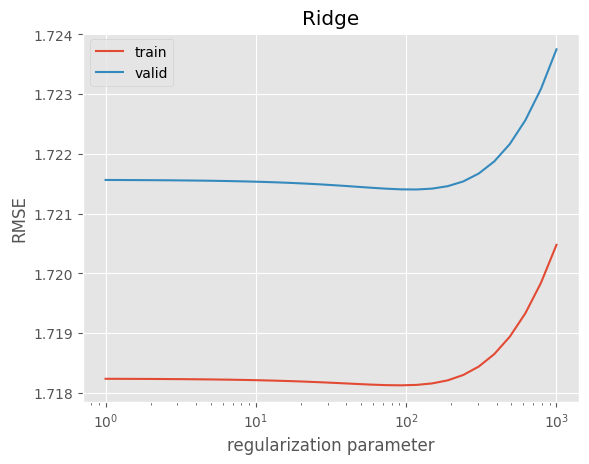

In [ ]:
plt.plot(alphas, ridge_rmse_train, label='train')
plt.plot(alphas, ridge_rmse_valid, label='valid')

plt.title('Ridge')
plt.xlabel('regularization parameter')
plt.ylabel('RMSE')
plt.legend()
plt.xscale('log')

In [ ]:
min_index = np.argmin(ridge_rmse_valid)
print("optimal alpha", alphas[min_index])
print("valid RMSE", ridge_rmse_valid[min_index])
print("train RMSE", ridge_rmse_train[min_index])

optimal alpha 45.20353656360243
valid RMSE 1.5112143338879045
train RMSE 1.5094634670686427


Notice that the model is barely overfitting when $\alpha$ is small, because the training RMSE only changes slightly. The validation set RMSE is higher than that of the training set; however, the validation RMSE barely changes as well so the model seems to need only a small amount of regularization.

The model starts to underfit for large $\alpha$. The effect of a large $\alpha$ is to increase the regularization strength, effectively make the model restricted in what coefficients it can use to fit the data. With a large $\lambda$ we see the model struggles on both the train and test data (high RMSE for both train and test data), indicating that the model is underfitting.

Thus, we need to choose an optimal regularization parameter, $\alpha^*$, that balances overfitting and underfitting. Use the graphical method to gain an understanding of the effects regularization has on a multiple regression model.

### LASSO regularization

Let's proceed now with an analogous analysis for the case of LASSO regularization, just for the sake of completeness.

Fitting with intercept is faster (requires less interations) than fitting without the intercept. Also the RMSE is smaller in the former case ($\sim 0.47$) for both training and validation datasets. The optimal of the regularization parameter is $\alpha^* \sim 1.3 \times 10^{-5}$ fitting with intercept, which is around half of that of the case of fitting without intercept.

In [ ]:
%%time

# loop through different alpha values
alphas = np.logspace(-4, -2, 30, endpoint=True)

lasso_rmse_train = []
lasso_rmse_valid = []

for index, alpha in enumerate(alphas):
    lasso = linear_model.Lasso(alpha=alpha, max_iter=80000, precompute=True, fit_intercept=False)
    lasso.fit(X_train, y_train)
    lasso_rmse_train.append(root_mean_squared_error(y_train**2, lasso.predict(X_train)**2))
    lasso_rmse_valid.append(root_mean_squared_error(y_valid, lasso.predict(X_valid)**2))
    print('done with', index, alpha)

done with 0 0.0001
done with 1 0.00011721022975334806
done with 2 0.00013738237958832623
done with 3 0.00016102620275609394
done with 4 0.00018873918221350977
done with 5 0.000221221629107045
done with 6 0.0002592943797404667
done with 7 0.0003039195382313198
done with 8 0.0003562247890262444
done with 9 0.00041753189365604
done with 10 0.0004893900918477494
done with 11 0.0005736152510448681
done with 12 0.0006723357536499335
done with 13 0.0007880462815669912
done with 14 0.0009236708571873865
done with 15 0.001082636733874054
done with 16 0.0012689610031679222
done with 17 0.0014873521072935117
done with 18 0.0017433288221999873
done with 19 0.0020433597178569417
done with 20 0.002395026619987486
done with 21 0.0028072162039411755
done with 22 0.0032903445623126675
done with 23 0.0038566204211634724
done with 24 0.004520353656360241
done with 25 0.005298316906283708
done with 26 0.006210169418915616
done with 27 0.007278953843983146
done with 28 0.008531678524172805
done with 29 0.0

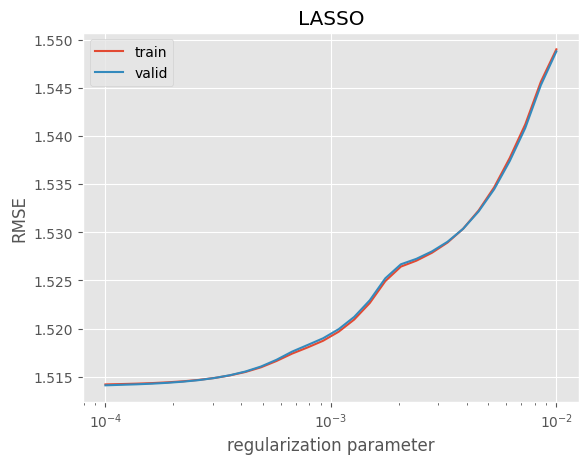

In [ ]:
plt.plot(alphas, lasso_rmse_train, label='train')
plt.plot(alphas, lasso_rmse_valid, label='valid')

plt.title('LASSO')
plt.xlabel('regularization parameter')
plt.ylabel('RMSE')
plt.legend()
plt.xscale('log')

In [ ]:
min_index = np.argmin(lasso_rmse_valid)
print("optimal alpha", alphas[min_index])
print("valid RMSE", lasso_rmse_valid[min_index])
print("train RMSE", lasso_rmse_train[min_index])

optimal alpha 0.0001
valid RMSE 1.514116721231674
train RMSE 1.514211083698815


We see that the LASSO results are very similar to those of Ridge. Therefore, the conclusions are similar as well. Notce that in this case the value of $\alpha$ always seems to be the lower value of the interval, meaning that no L2 regularization is necessary (?).

## Cross-validation

It is not wise to just construct the validation set to a _fix_ subset of the dataset. This can lead to problems due to the following factors.

> 1. If the dataset is small, the size of the training set reduces and our models will have less predictive power.
> 2. The choice of the regularization parameter will end up being highly dependent on the _fixed_ validation set.

Thus, it is often recommended to use a method such as [$k$-fold cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) to estimate the best parameter $\alpha$.

Just because Ridge is faster let's try cross-validation using it before trying LASSO...

In [ ]:
# feature variable transformation
cols_to_sqrt = ['rho', 'dx', 'dy', 'dz']    # 'K', 'G'
X_rest[cols_to_sqrt] = X_rest[cols_to_sqrt].apply(np.sqrt)

cols_to_log = [col for col in kg_df.columns if col.startswith('omega2_')]
X_rest[cols_to_log] = X_rest[cols_to_log].apply(np.log)

In [ ]:
%%time

"""IMPORTANT:
For cross-validation, when should the variable transformations be performed?
"""

mae_train_total, rmse_train_total, mape_train_total = [], [], []
mae_valid_total, rmse_valid_total, mape_valid_total = [], [], []
kf = KFold(n_splits=10, shuffle=True)#, random_state=0)

alphas = np.logspace(1, 2, 90, endpoint=True)    # Ridge
# alphas = np.logspace(-7, -5, 50, endpoint=True)    # LASSO

for fold_num, (index_train, index_valid) in enumerate(kf.split(X_rest)):
    # extract the data of the fold
    X_train_fold, y_train_fold = X_rest.iloc[index_train].copy(), y_rest[index_train]
    X_valid_fold, y_valid_fold = X_rest.iloc[index_valid].copy(), y_rest[index_valid]

    # target variable transformation
    y_train_fold = np.sqrt(y_train_fold)

    # # standardize/scale the data
    # scaler = StandardScaler()
    # X_train_fold = scaler.fit_transform(X_train_fold)
    # X_test_fold = scaler.transform(X_test_fold)
    # don't forget to undo the transformation to make predictions

    mae_train_fold, rmse_train_fold, mape_train_fold = [], [], []
    mae_valid_fold, rmse_valid_fold, mape_valid_fold = [], [], []

    for ell in alphas:
        fold_model = linear_model.Ridge(alpha=ell, max_iter=8000, fit_intercept=True)
        # fold_model = linear_model.Lasso(alpha=ell, max_iter=80000, precompute=True, fit_intercept=True)
        fold_model.fit(X_train_fold, y_train_fold)

        # compute RMSE, MAE and MAPE for training and validation data
        y_valid_fold_hat = fold_model.predict(X_valid_fold) ** 2
        y_train_fold_hat = fold_model.predict(X_train_fold) ** 2

        mae_valid_fold.append(mean_absolute_error(y_valid_fold, y_valid_fold_hat))
        rmse_valid_fold.append(root_mean_squared_error(y_valid_fold, y_valid_fold_hat))
        mape_valid_fold.append(mean_absolute_percentage_error(y_valid_fold, y_valid_fold_hat))

        mae_train_fold.append(mean_absolute_error(y_train_fold ** 2, y_train_fold_hat))
        rmse_train_fold.append(root_mean_squared_error(y_train_fold ** 2, y_train_fold_hat))
        mape_train_fold.append(mean_absolute_percentage_error(y_train_fold ** 2, y_train_fold_hat))

    mae_valid_total.append(mae_valid_fold)
    rmse_valid_total.append(rmse_valid_fold)
    mape_valid_total.append(mape_valid_fold)

    mae_train_total.append(mae_train_fold)
    rmse_train_total.append(rmse_train_fold)
    mape_train_total.append(mape_train_fold)

    print('done with fold', fold_num)

done with fold 0
done with fold 1
done with fold 2
done with fold 3
done with fold 4
done with fold 5
done with fold 6
done with fold 7
done with fold 8
done with fold 9
CPU times: user 20.2 s, sys: 6.41 s, total: 26.7 s
Wall time: 21.6 s


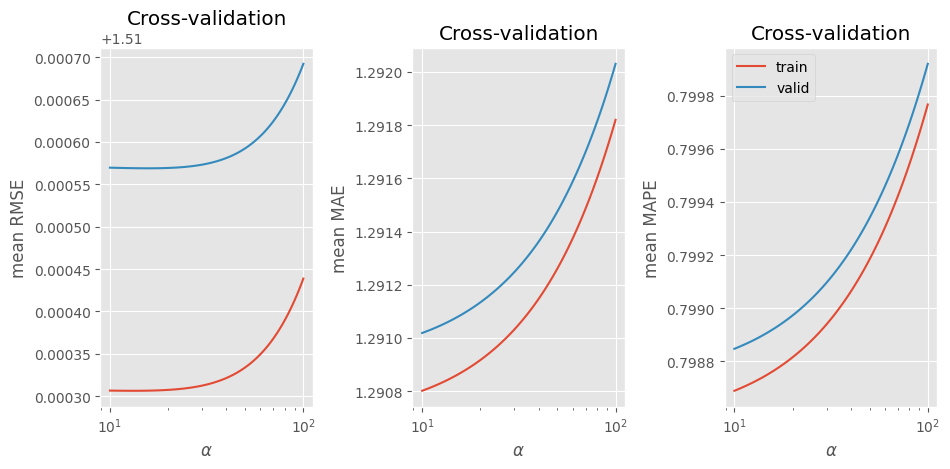

In [ ]:
# compute mean RMSE for each alpha
mae_train_alphas = np.matrix(mae_train_total).mean(0).reshape(len(alphas), 1)
rmse_train_alphas = np.matrix(rmse_train_total).mean(0).reshape(len(alphas), 1)
mape_train_alphas = np.matrix(mape_train_total).mean(0).reshape(len(alphas), 1)

mae_valid_alphas = np.matrix(mae_valid_total).mean(0).reshape(len(alphas), 1)
rmse_valid_alphas = np.matrix(rmse_valid_total).mean(0).reshape(len(alphas), 1)
mape_valid_alphas = np.matrix(mape_valid_total).mean(0).reshape(len(alphas), 1)

plt.figure(figsize=(9.6, 4.8))

plt.subplot(1, 3, 1)
plt.plot(alphas, rmse_train_alphas, label='train')
plt.plot(alphas, rmse_valid_alphas, label='valid')
plt.xscale('log')
plt.title('Cross-validation')
plt.xlabel(r'$\alpha$')
plt.ylabel('mean RMSE')

plt.subplot(1, 3, 2)
plt.plot(alphas, mae_train_alphas, label='train')
plt.plot(alphas, mae_valid_alphas, label='valid')
plt.xscale('log')
plt.title('Cross-validation')
plt.xlabel(r'$\alpha$')
plt.ylabel('mean MAE')

plt.subplot(1, 3, 3)
plt.plot(alphas, mape_train_alphas, label='train')
plt.plot(alphas, mape_valid_alphas, label='valid')
plt.xscale('log')
plt.title('Cross-validation')
plt.xlabel(r'$\alpha$')
plt.ylabel('mean MAPE')

plt.legend()
plt.tight_layout()

In [ ]:
min_index = np.argmin(rmse_valid_alphas)
print("optimal alpha", alphas[min_index])
print("mean RMSE", rmse_valid_alphas[min_index])
print("mean MAE", mae_valid_alphas[min_index])
print("mean MAPE", mape_valid_alphas[min_index])

optimal alpha 15.524271734347947
mean RMSE [[1.51056888]]
mean MAE [[1.29108229]]
mean MAPE [[0.79891675]]


Let's evaluate the final performance of the model with the optival value of $\alpha$ on the `test` dataset.

In [ ]:
cv_optimal_alpha = alphas[min_index]
print('the alpha', cv_optimal_alpha)

cv_model = linear_model.Lasso(alpha=cv_optimal_alpha, max_iter=8000, fit_intercept=True)
cv_model.fit(X_train, y_train)

y_test_hat = cv_model.predict(X_test) ** 2.

mae_test = mean_absolute_error(y_test, y_test_hat)
rmse_test = root_mean_squared_error(y_test, y_test_hat)
mape_test = mean_absolute_percentage_error(y_test, y_test_hat)

print("test MAE", mae_test)
print("test RMSE", rmse_test)
print("test MAPE", mape_test)

the alpha 15.524271734347947
test MAE 1.3421958436603918
test RMSE 1.554262640349036
test MAPE 0.8477574217307894
